In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random as ra
import math

In [2]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16     
out_size = 10
epochs = 10            
batch_size = 64
learning_rate = 0.001

In [3]:
test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [4]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)     #784 - 32
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)   #32 - 16
        self.fc2 = nn.Linear(hidden_size1, out_size)       #16 - 10
        self.tanh = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc0.weight, gain=nn.init.calculate_gain('tanh')) 
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('tanh'))

    def forward(self, x):
        out = self.tanh(self.fc0(x))
        out = self.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [5]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

In [6]:
net.load_state_dict(torch.load("02_ffn_mnist_full.pth"))

<All keys matched successfully>

In [7]:
def compute_final_contributions(net, activations_fc0, target):
    w1 = net.fc1.weight.detach().cpu()
    w2 = net.fc2.weight.detach().cpu()

    contribs = torch.zeros(activations_fc0.shape[0])

    for i in range(activations_fc0.shape[0]):
        a0 = activations_fc0[i].item()
        total = 0
        for j in range(w1.shape[0]):
            w0 = w1[j, i].item()
            a1 = torch.tanh(torch.tensor(a0 * w0))
            w1_2 = w2[target, j].item()
            total += a1.item() * w1_2
        contribs[i] = total

    return contribs



Prediction: 5


/tmp/ipykernel_38655/950244714.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


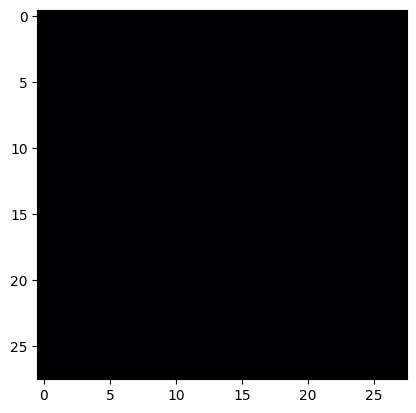

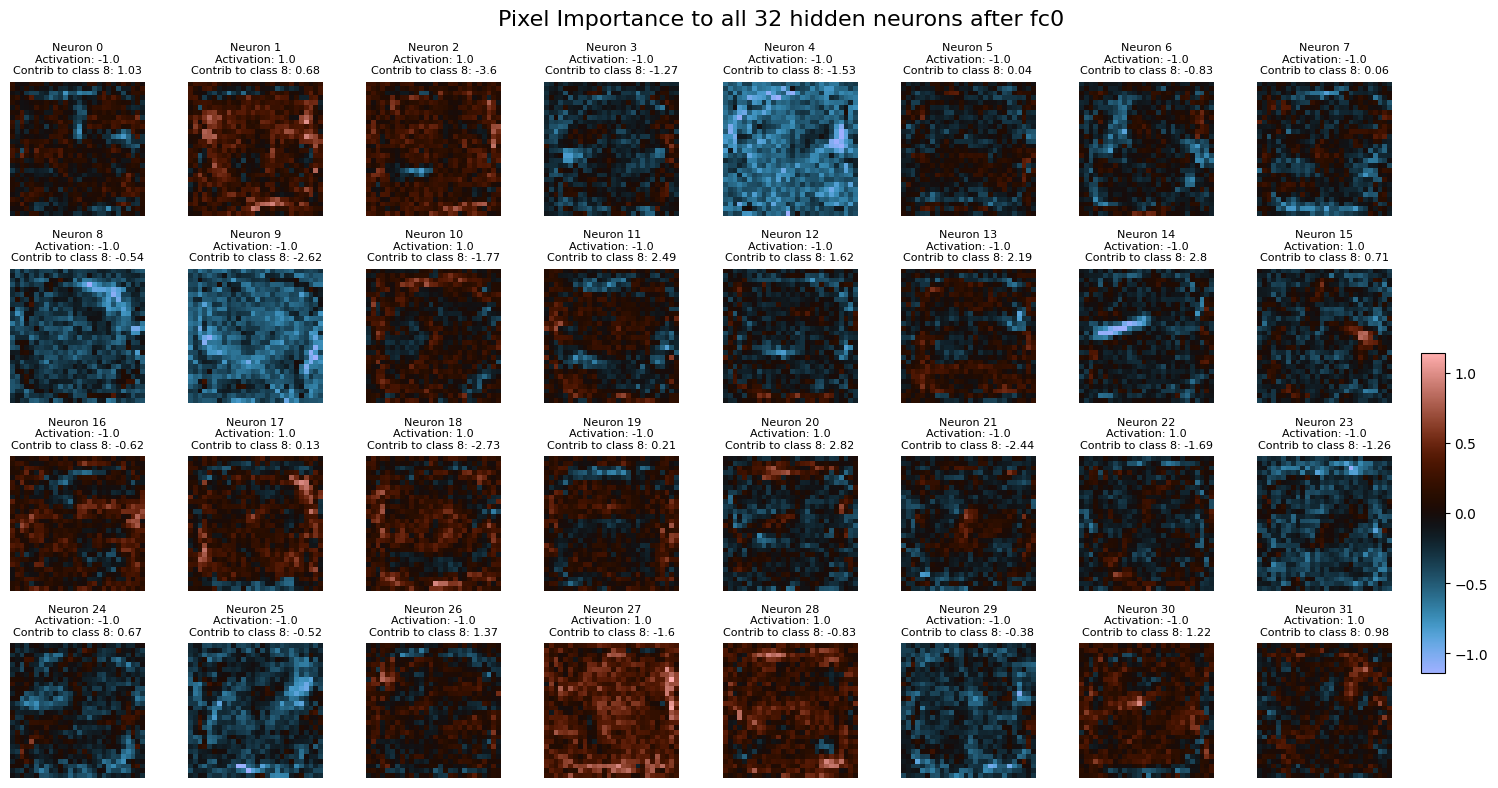

In [8]:

inputs, labels = next(iter(test_loader))
dig_to_check = 8

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == dig_to_check:
        img = inputs[ind].squeeze()
        break
img = torch.full((28, 28), 255).float()

output = net(img.view(-1).cuda())
print(f"Prediction: {output.argmax()}")
plt.imshow(img, cmap="inferno")

img_flat = img.view(-1)
weights = net.fc0.weight.detach().cpu()
biases = net.fc0.bias.detach().cpu()
contribs = weights * img_flat #[32, 784]

#normalise to [0, 1]
contribs_imgs = (contribs / contribs.max()).view(-1, 28, 28)

mask = torch.where(
    contribs_imgs == 0,
    torch.tensor(0.0, device=contribs_imgs.device),
    torch.tensor(1.0, device=contribs_imgs.device)
)

contribs_imgs += biases[:, None, None]
#contribs_imgs *= mask #remove bias where background = 0 for visualisation 

activations = torch.tanh(net.fc0(img.view(1, -1).cuda())).squeeze()
final_contribution = [round(con.item(), 2) for con in compute_final_contributions(net, activations, dig_to_check)]

fig, axes = plt.subplots(4, 8, figsize=(16, 8))
vmax = contribs_imgs.max().item()

for i, ax in enumerate(axes.flat):
    im = ax.imshow(contribs_imgs[i], cmap='berlin', vmin=-vmax, vmax=vmax)
    ax.set_title(f'Neuron {i}\nActivation: {round(activations[i].item(), 3)}\nContrib to class {dig_to_check}: {final_contribution[i]}', fontsize=8)
    ax.axis('off')

fig.suptitle('Pixel Importance to all 32 hidden neurons after fc0', fontsize=16)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.4])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()



In [9]:
net1 = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net1 = net1.cuda()

net1.load_state_dict(torch.load("stored_model_weights/model_inst_1"))

<All keys matched successfully>

/tmp/ipykernel_38655/1341310283.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])


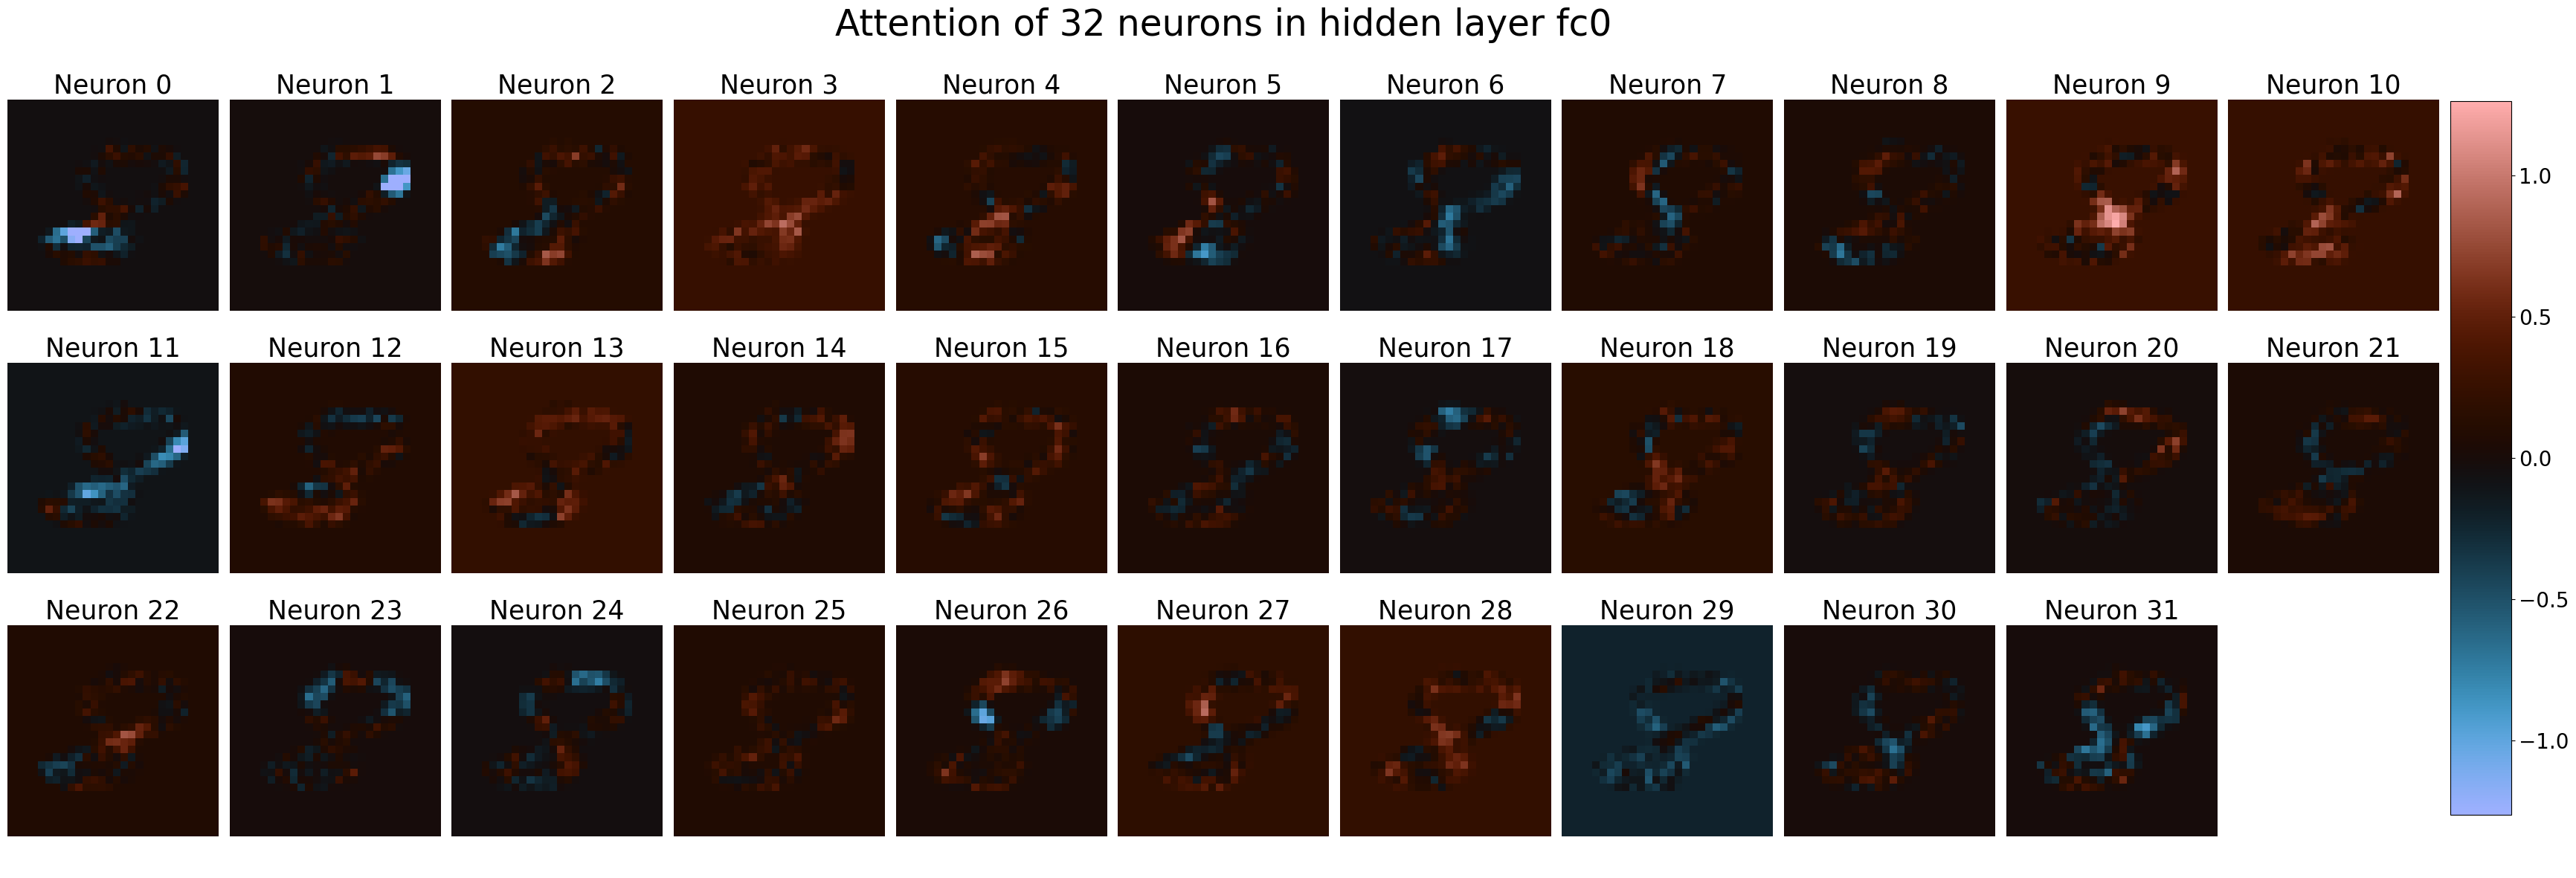

In [31]:

inputs, labels = next(iter(test_loader))
dig_to_check = 8

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == dig_to_check:
        img = inputs[ind].squeeze()
        break
# img = torch.full((28, 28), 255).float()

output = net1(img.view(-1).cuda())
#print(f"Prediction: {output.argmax()}")
#plt.imshow(img, cmap="inferno")

img_flat = img.view(-1)
weights = net1.fc0.weight.detach().cpu()
biases = net1.fc0.bias.detach().cpu()
contribs = weights * img_flat #[32, 784]

#normalise to [0, 1]
contribs_imgs1 = (contribs / contribs.max()).view(-1, 28, 28)

mask = torch.where(
    contribs_imgs1 == 0,
    torch.tensor(0.0, device=contribs_imgs1.device),
    torch.tensor(1.0, device=contribs_imgs1.device)
)

contribs_imgs1 += biases[:, None, None]
#contribs_imgs1 *= mask #remove bias where background = 0 for visualisation 

activations = torch.tanh(net1.fc0(img.view(1, -1).cuda())).squeeze()
final_contribution = [round(con.item(), 2) for con in compute_final_contributions(net1, activations, dig_to_check)]

fig, axes = plt.subplots(3, 11, figsize=(33, 12))
vmax = contribs_imgs1.max().item()

for i, ax in enumerate(axes.flat):
    if i <= 31:
        im = ax.imshow(contribs_imgs1[i], cmap='berlin', vmin=-vmax, vmax=vmax)
        ax.set_title(f'Neuron {i}', fontsize=25) #\nActivation: {round(activations[i].item(), 3)} #\nContrib to class {dig_to_check}: {final_contribution[i]}', fontsize=20)
    
    ax.axis('off')
        
        

fig.suptitle('Attention of 32 neurons in hidden layer fc0', fontsize=35)
cbar_ax = fig.add_axes([1, 0.075, 0.025, 0.8])
fig.colorbar(im, cax=cbar_ax)
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()



(0.26852159132249653,
 0.2693451941013336,
 0.4793653190135956,
 0.03308602422475815)

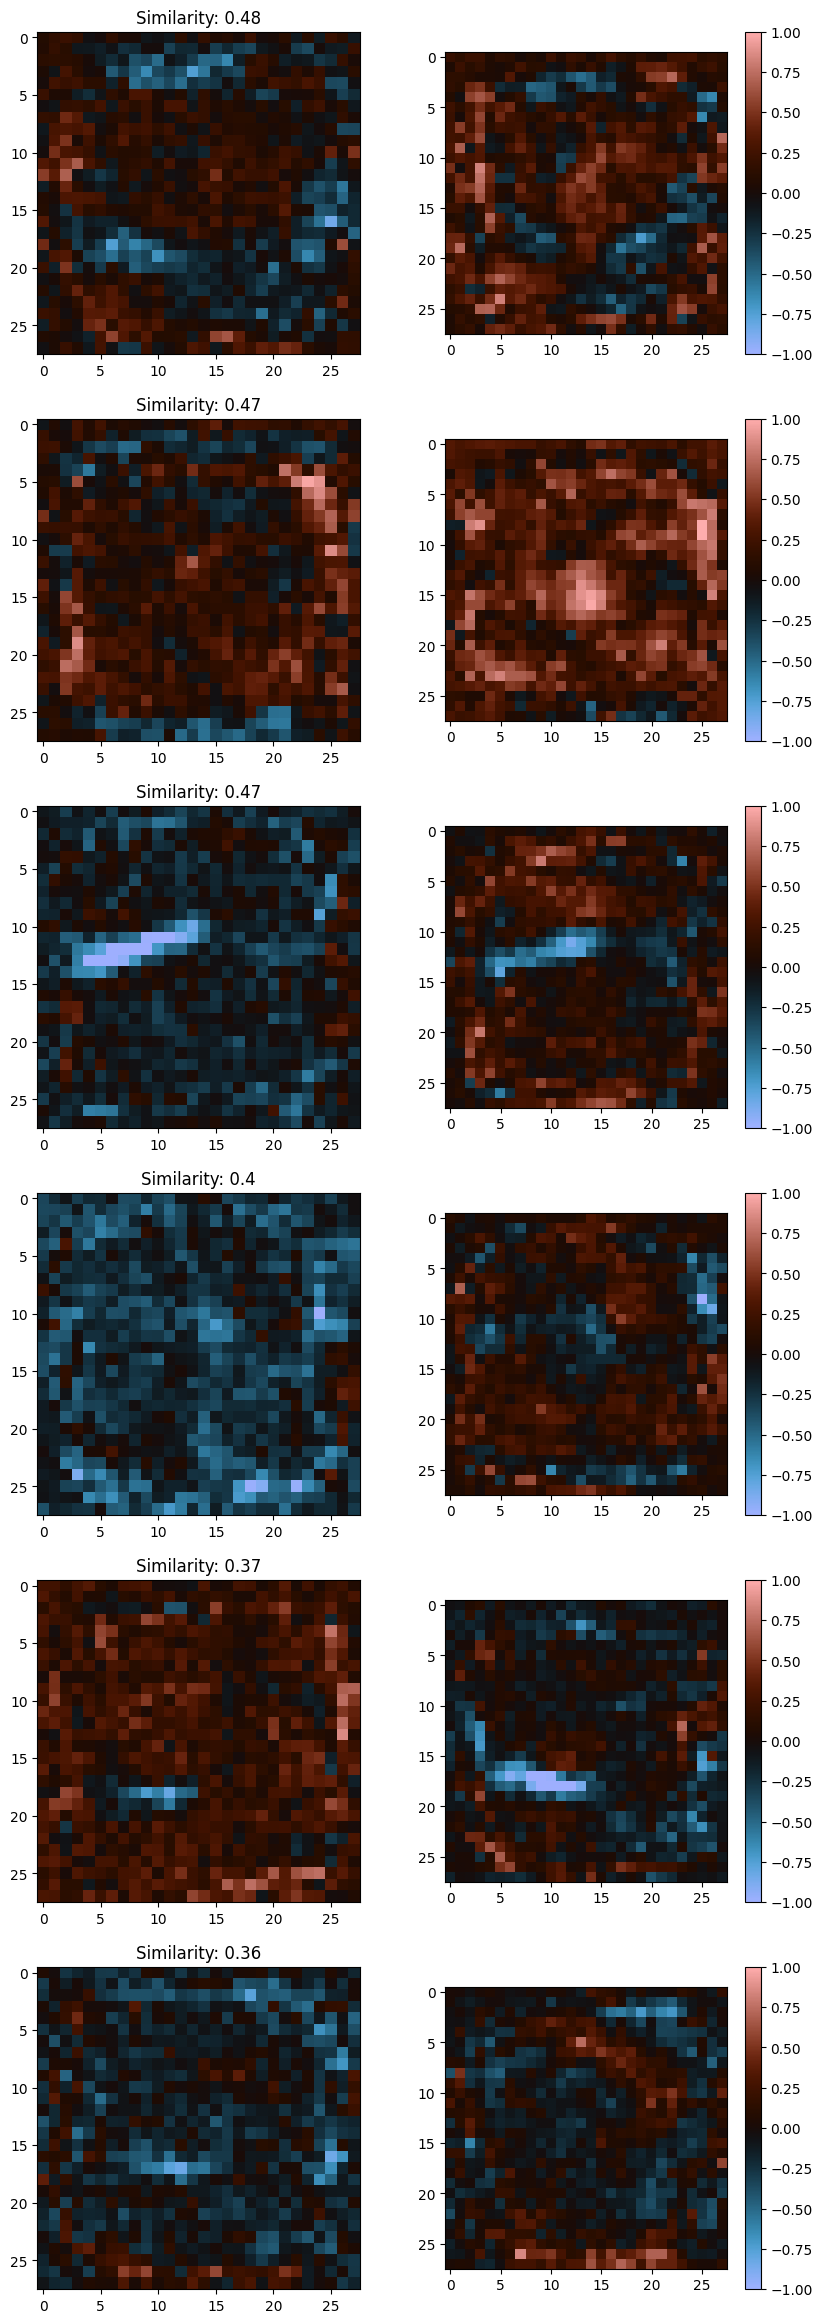

In [11]:
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment

def normalize_map(t):
    return (t - t.mean()) / (t.std() + 1e-8)

def similarity_score(map1, map2):
    a = normalize_map(map1).view(-1)
    b = normalize_map(map2).view(-1)
    #return torch.norm(a - b, p=2).item()
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()


mask = (img != 0)
mask_flat = mask.flatten()

flat_imgs = contribs_imgs.view(contribs_imgs.shape[0], -1)
flat_imgs1 = contribs_imgs1.view(contribs_imgs1.shape[0], -1)

masked_imgs = flat_imgs[:, mask_flat]
masked_imgs1 = flat_imgs1[:, mask_flat]

sim_matrix = torch.zeros((32, 32))

for i in range(32):
    for j in range(32):
        sim_matrix[i, j] = similarity_score(masked_imgs[i], masked_imgs1[j])

cost = -sim_matrix.numpy()
row_ind, col_ind = linear_sum_assignment(cost)
max_vals = sim_matrix[row_ind, col_ind].tolist()

pairs = list(zip(row_ind, col_ind, max_vals))
pairs.sort(key=lambda x: x[2], reverse=True)

#calculate mean:
sum_sims = 0
sims = []
for i, (r, c, sim) in enumerate(pairs):
    sum_sims += sim
    sims.append(sim)



plt.figure(figsize=(10, 160))

for i, (r, c, sim) in enumerate(pairs):
    plt.subplot(32, 2, i*2+1)
    plt.imshow(contribs_imgs[r], cmap="berlin", vmin=-1, vmax=1)
    plt.title(f"Similarity: {round(sim, 2)}")
    plt.subplot(32, 2, i*2+2)
    plt.imshow(contribs_imgs1[c], cmap="berlin", vmin=-1, vmax=1)
    plt.colorbar()

    if i > 4:
        break


sum_mean = sum_sims / len(pairs)
sum_med = float(torch.median(torch.Tensor(sims)))
sum_max = max(sims)
sum_min = min(sims)

sum_mean, sum_med, sum_max, sum_min

/tmp/ipykernel_38655/3364541302.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


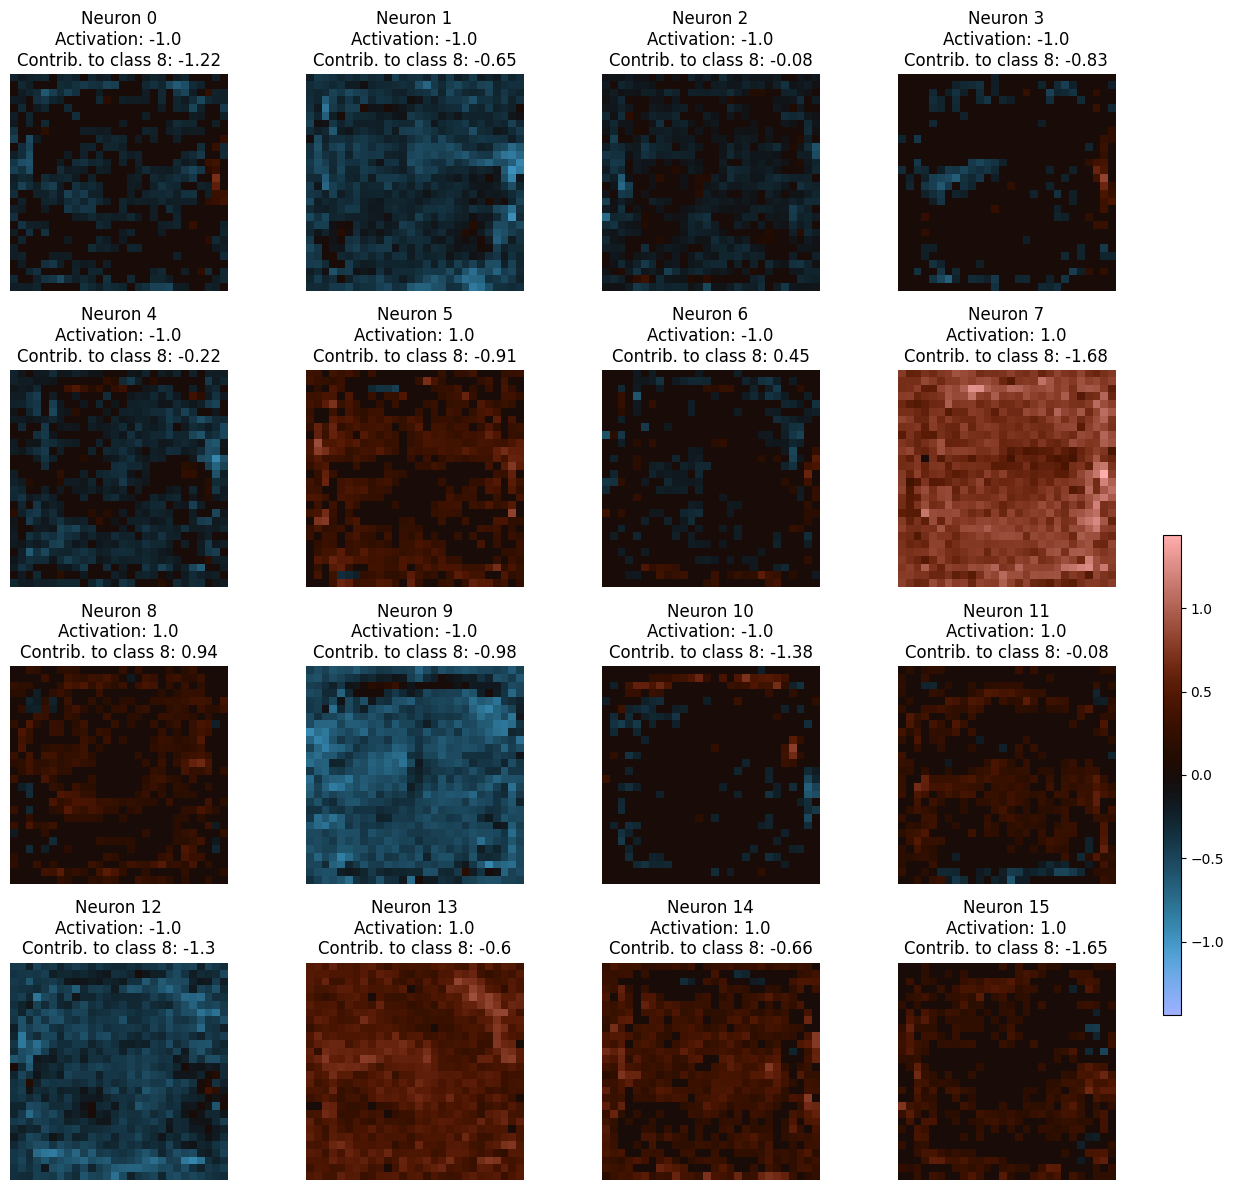

In [12]:
weights_fc1 = net.fc1.weight.detach().cpu().unsqueeze(-1).unsqueeze(-1)
biases_fc1 = net.fc1.bias.detach().cpu()

combined = (weights_fc1 * contribs_imgs.unsqueeze(0)).sum(dim=1)
max_val = combined.max()
combined = combined / max_val

mask = torch.where(
    combined == 0,
    torch.tensor(0.0, device=combined.device),
    torch.tensor(1.0, device=combined.device)
)

combined += biases_fc1[:, None, None]
#combined *= mask

combined_copy = combined.clone()

per_img_max = combined.view(len(combined), -1).max(dim=1)[0]
thresholds = (0.25 * per_img_max).view(len(combined), 1, 1)

combined = torch.where(
    combined == 0,
    torch.tensor(0.0, device=combined.device),
    torch.where(
        torch.abs(combined) > thresholds,
        combined,
        torch.tensor(0.0, device=combined.device)
    )
)
vmax = combined.max().item()

weights_fc2 = net.fc2.weight.detach().cpu()
activations = [torch.tanh(mat.sum()).squeeze() for mat in combined_copy]

contribs_out_class = [round(activations[idx].item() * weights_fc2[dig_to_check, idx].item(), 2) for idx in range(16)]

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for idx, ax in enumerate(axes.flat):
    im = ax.imshow(combined[idx].cpu(), cmap='berlin', vmin=-vmax, vmax=vmax)
    ax.axis('off')
    ax.set_title(f'Neuron {idx}\nActivation: {round(activations[idx].item(), 2)}\nContrib. to class {dig_to_check}: {contribs_out_class[idx]}')

cbar_ax = fig.add_axes([1, 0.15, 0.015, 0.4])
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout()
plt.show()


/tmp/ipykernel_38655/2586930220.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])


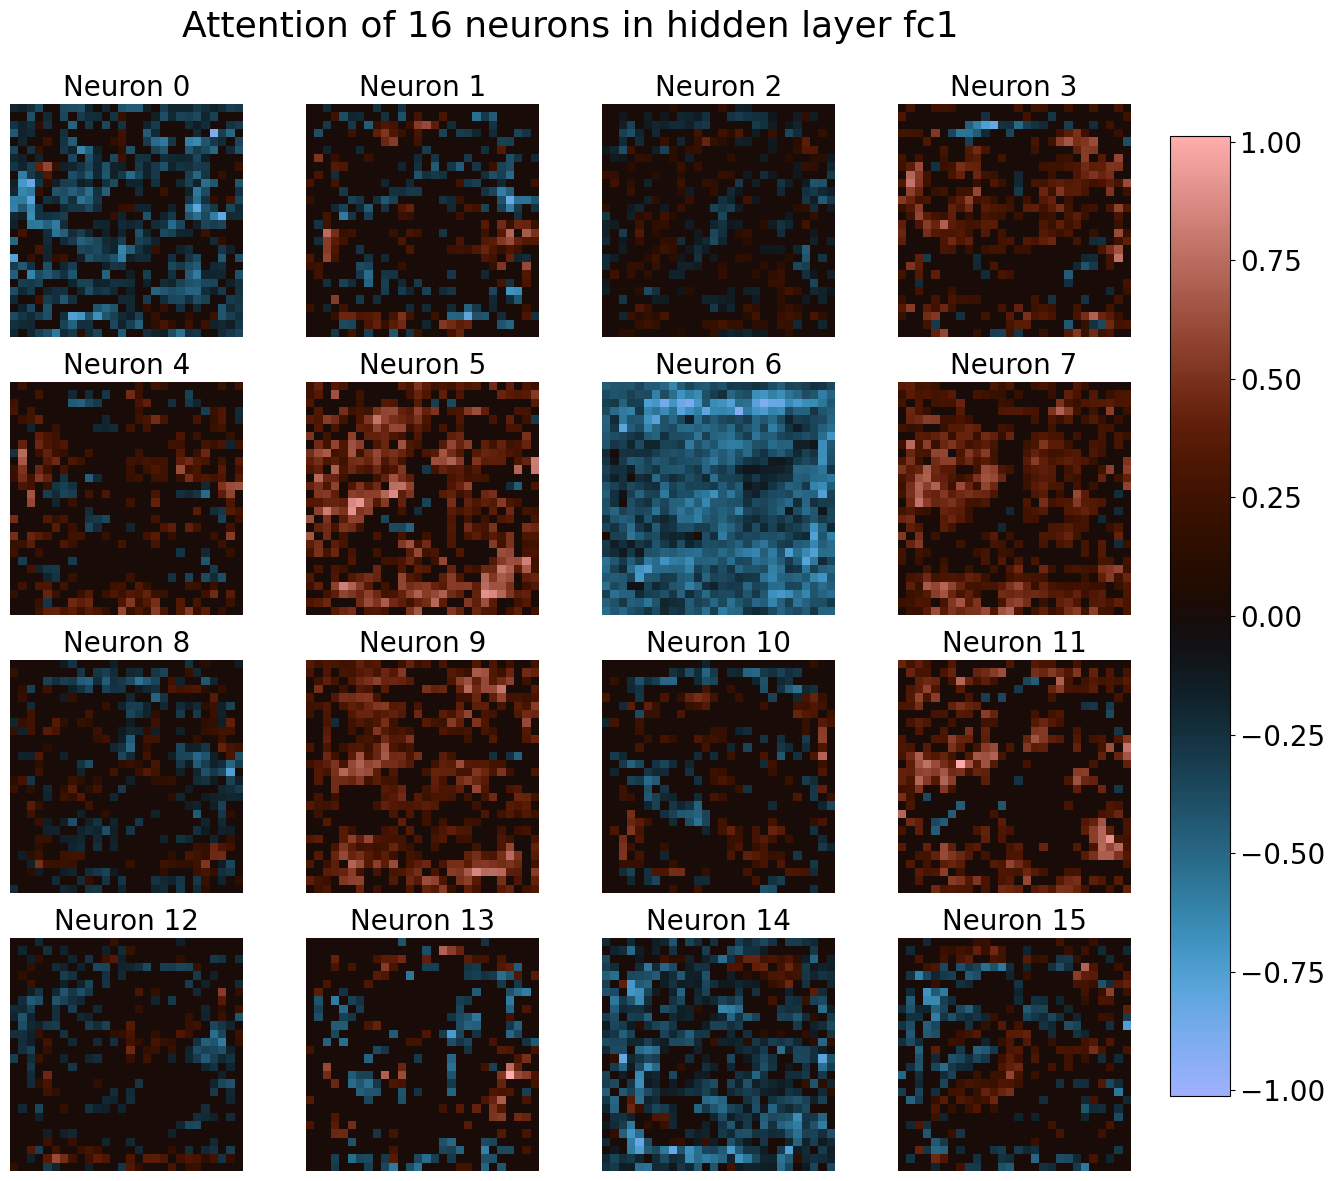

In [13]:
weights_fc1 = net1.fc1.weight.detach().cpu().unsqueeze(-1).unsqueeze(-1)
biases_fc1 = net1.fc1.bias.detach().cpu()

combined1 = (weights_fc1 * contribs_imgs.unsqueeze(0)).sum(dim=1)
max_val = combined1.max()
combined1 = combined1 / max_val

mask = torch.where(
    combined1 == 0,
    torch.tensor(0.0, device=combined1.device),
    torch.tensor(1.0, device=combined1.device)
)

combined1 += biases_fc1[:, None, None]
#combined1 *= mask

combined1_copy = combined1.clone()

per_img_max = combined1.view(len(combined1), -1).max(dim=1)[0]
thresholds = (0.25 * per_img_max).view(len(combined1), 1, 1)

combined1 = torch.where(
    combined1 == 0,
    torch.tensor(0.0, device=combined1.device),
    torch.where(
        torch.abs(combined1) > thresholds,
        combined1,
        torch.tensor(0.0, device=combined1.device)
    )
)

vmax = combined1.max().item()

weights_fc2 = net1.fc2.weight.detach().cpu()
activations = [torch.tanh(mat.sum()).squeeze() for mat in combined1_copy]

contribs_out_class = [round(activations[idx].item() * weights_fc2[dig_to_check, idx].item(), 2) for idx in range(16)]

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for idx, ax in enumerate(axes.flat):
    im = ax.imshow(combined1[idx].cpu(), cmap='berlin', vmin=-vmax, vmax=vmax)
    ax.axis('off')
    ax.set_title(f'Neuron {idx}', fontsize=20) #\nActivation: {round(activations[idx].item(), 2)}\nContrib. to class {dig_to_check}: {contribs_out_class[idx]}')

cbar_ax = fig.add_axes([1, 0.075, 0.05, 0.8])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('Attention of 16 neurons in hidden layer fc1', fontsize=26)
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


16


(0.28331098100170493,
 0.2889249324798584,
 0.4959249198436737,
 0.06791992485523224)

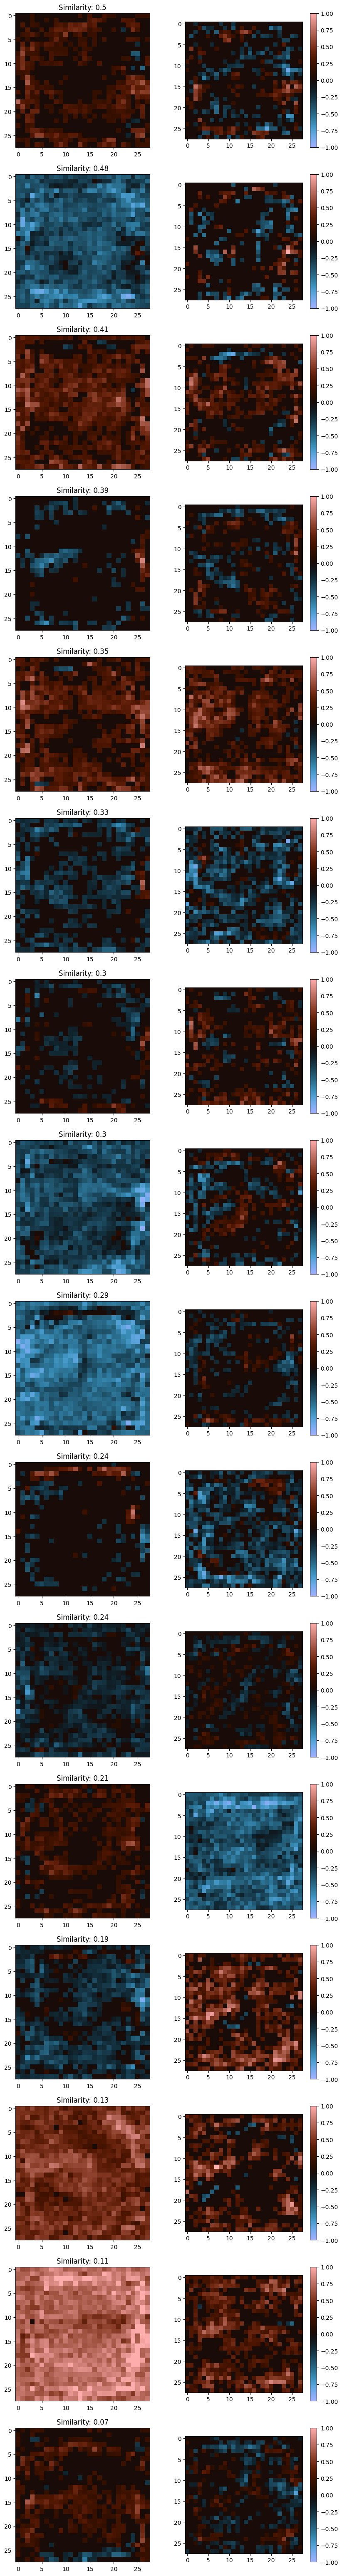

In [14]:
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment

def normalize_map(t):
    return (t - t.mean()) / (t.std() + 1e-8)

def similarity_score(map1, map2):
    a = normalize_map(map1).view(-1)
    b = normalize_map(map2).view(-1)
    #return torch.norm(a - b, p=2).item()
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()


mask = (img != 0)
mask_flat = mask.flatten()

flat_imgs = combined.view(combined.shape[0], -1)
flat_imgs1 = combined1.view(combined1.shape[0], -1)

masked_imgs = flat_imgs[:, mask_flat]
masked_imgs1 = flat_imgs1[:, mask_flat]

sim_matrix = torch.zeros((16, 16))

for i in range(16):
    for j in range(16):
        sim_matrix[i, j] = similarity_score(masked_imgs[i], masked_imgs1[j])

cost = -sim_matrix.numpy()
row_ind, col_ind = linear_sum_assignment(cost)
max_vals = sim_matrix[row_ind, col_ind].tolist()

pairs = list(zip(row_ind, col_ind, max_vals))
pairs.sort(key=lambda x: x[2], reverse=True)


plt.figure(figsize=(10, 160))

for i, (r, c, sim) in enumerate(pairs):
    if r >= 16: break
    
    plt.subplot(32, 2, i*2+1)
    plt.imshow(combined[r], cmap="berlin", vmin=-1, vmax=1)
    plt.title(f"Similarity: {round(sim, 2)}")
    plt.subplot(32, 2, i*2+2)
    plt.imshow(combined1[c], cmap="berlin", vmin=-1, vmax=1)
    plt.colorbar()

    if i > 4:
        pass

print(len(pairs))

#calculate mean:
sum_sims = 0
sims = []
for i, (r, c, sim) in enumerate(pairs):
    sum_sims += sim
    sims.append(sim)
    
sum_mean = sum_sims / len(pairs)
sum_med = float(torch.median(torch.Tensor(sims)))
sum_max = max(sims)
sum_min = min(sims)

sum_mean, sum_med, sum_max, sum_min

/tmp/ipykernel_38655/1411452214.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


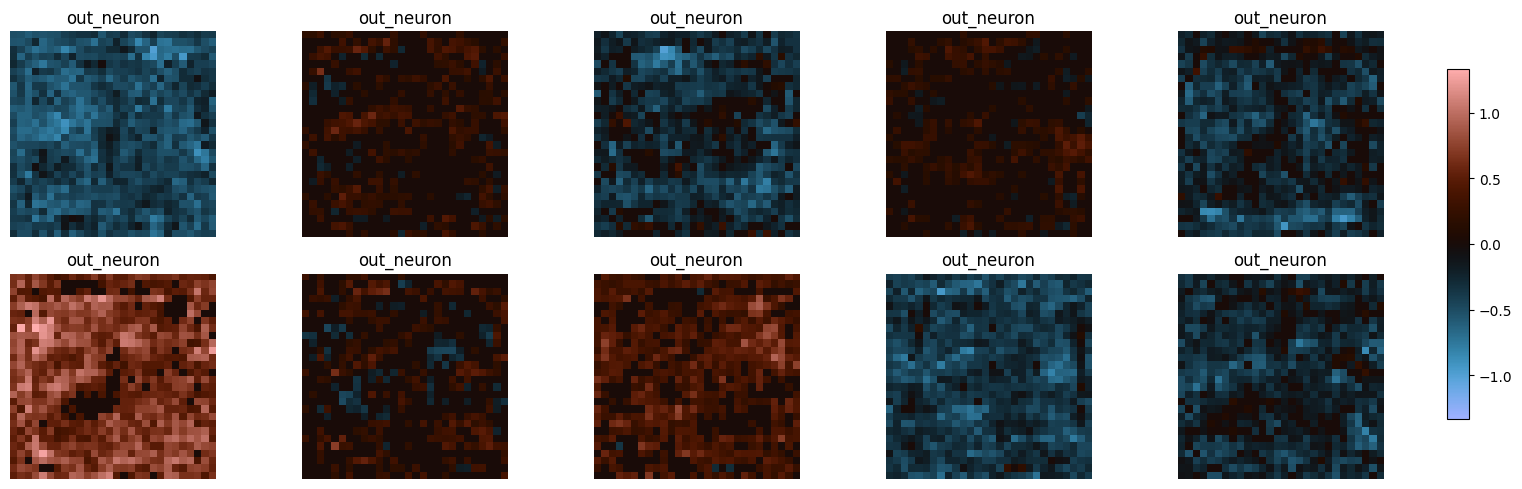

In [15]:
weights_fc2 = net.fc2.weight.detach().cpu().unsqueeze(-1).unsqueeze(-1)
biases_fc2 = net.fc2.bias.detach().cpu()

combined_out = (weights_fc2 * combined1.unsqueeze(0)).sum(dim=1)
max_val = combined_out.max()
combined_out = combined_out / max_val

mask = torch.where(
    combined_out == 0,
    torch.tensor(0.0, device=combined_out.device),
    torch.tensor(1.0, device=combined_out.device)
)

combined_out += biases_fc2[:, None, None]
#combined_out *= mask

combined_out_copy = combined_out.clone()

per_img_max = combined_out.view(len(combined_out), -1).max(dim=1)[0]
thresholds = (0.25 * per_img_max).view(len(combined_out), 1, 1)

combined_out = torch.where(
    combined_out == 0,
    torch.tensor(0, device=combined_out.device),
    torch.where(
        torch.abs(combined_out) > thresholds,
        combined_out,
        torch.tensor(0, device=combined_out.device)
    )
)

vmax = combined_out.max().item()

fig, axes = plt.subplots(2, 5, figsize=(15, 5))
for idx, ax in enumerate(axes.flat):
    im = ax.imshow(combined_out[idx].cpu(), cmap='berlin', vmin=-vmax, vmax=vmax)
    ax.axis('off')
    ax.set_title("out_neuron")

cbar_ax = fig.add_axes([1.0, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout()
plt.show()

/tmp/ipykernel_38655/1881125050.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 1])


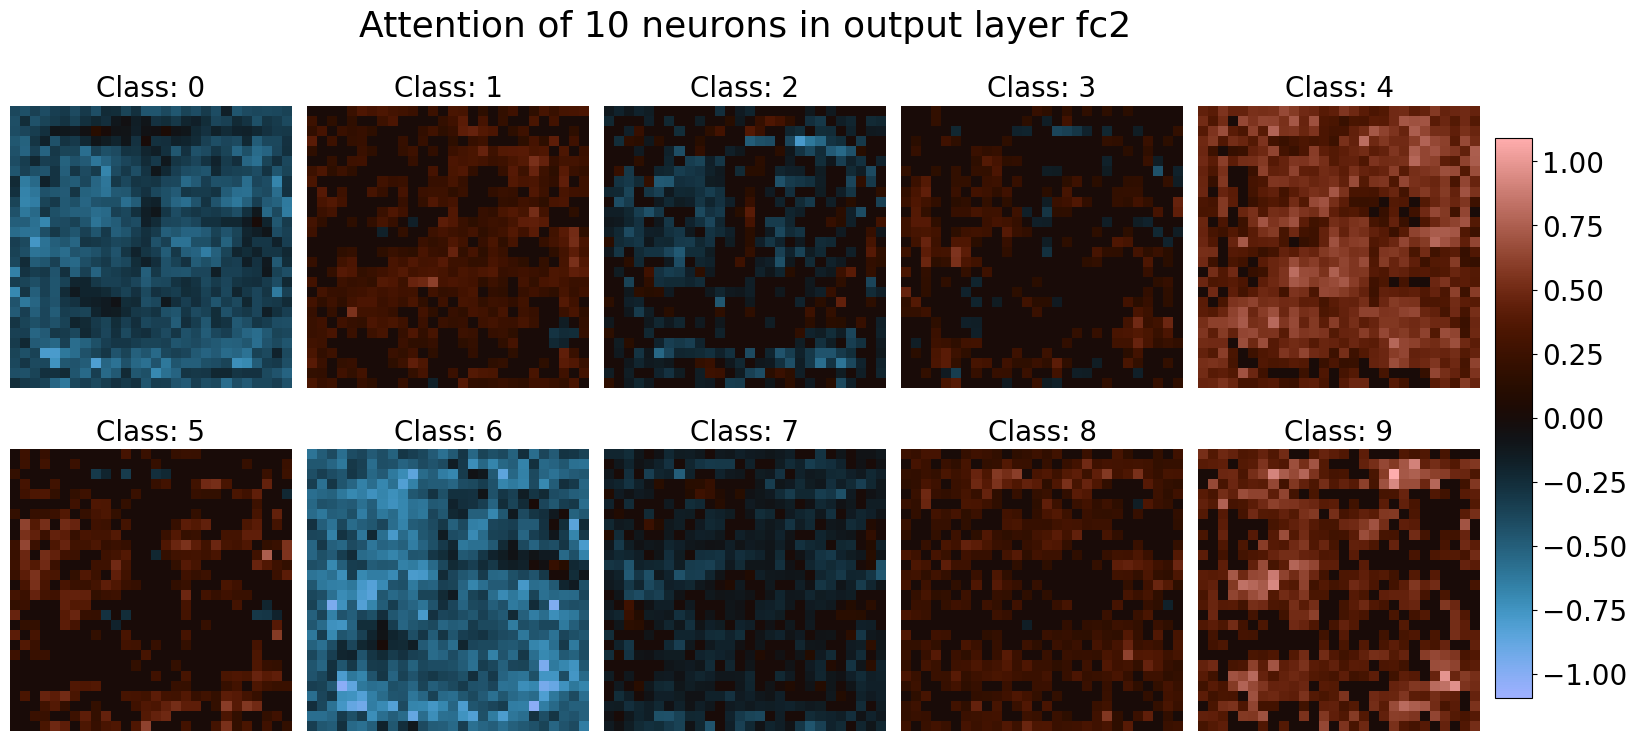

In [16]:
weights_fc2 = net1.fc2.weight.detach().cpu().unsqueeze(-1).unsqueeze(-1)
biases_fc2 = net1.fc2.bias.detach().cpu()

combined_out1 = (weights_fc2 * combined1.unsqueeze(0)).sum(dim=1)
max_val = combined_out1.max()
combined_out1 = combined_out1 / max_val

mask = torch.where(
    combined_out1 == 0,
    torch.tensor(0.0, device=combined_out1.device),
    torch.tensor(1.0, device=combined_out1.device)
)

combined_out1 += biases_fc2[:, None, None]
#combined_out1 *= mask

combined_out1_copy = combined_out1.clone()

per_img_max = combined_out1.view(len(combined_out1), -1).max(dim=1)[0]
thresholds = (0.25 * per_img_max).view(len(combined_out1), 1, 1)

combined_out1 = torch.where(
    combined_out1 == 0,
    torch.tensor(0, device=combined_out1.device),
    torch.where(
        torch.abs(combined_out1) > thresholds,
        combined_out1,
        torch.tensor(0, device=combined_out1.device)
    )
)

vmax = combined_out1.max().item()

fig, axes = plt.subplots(2, 5, figsize=(15, 8))
for idx, ax in enumerate(axes.flat):
    im = ax.imshow(combined_out1[idx].cpu(), cmap='berlin', vmin=-vmax, vmax=vmax)
    ax.axis('off')
    ax.set_title(f"Class: {idx}", fontsize=20)

cbar_ax = fig.add_axes([1, 0.12, 0.025, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('Attention of 10 neurons in output layer fc2', fontsize=26)
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=20)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()



(0.44446206986904147,
 0.44296514987945557,
 0.6079576015472412,
 0.2698514461517334)

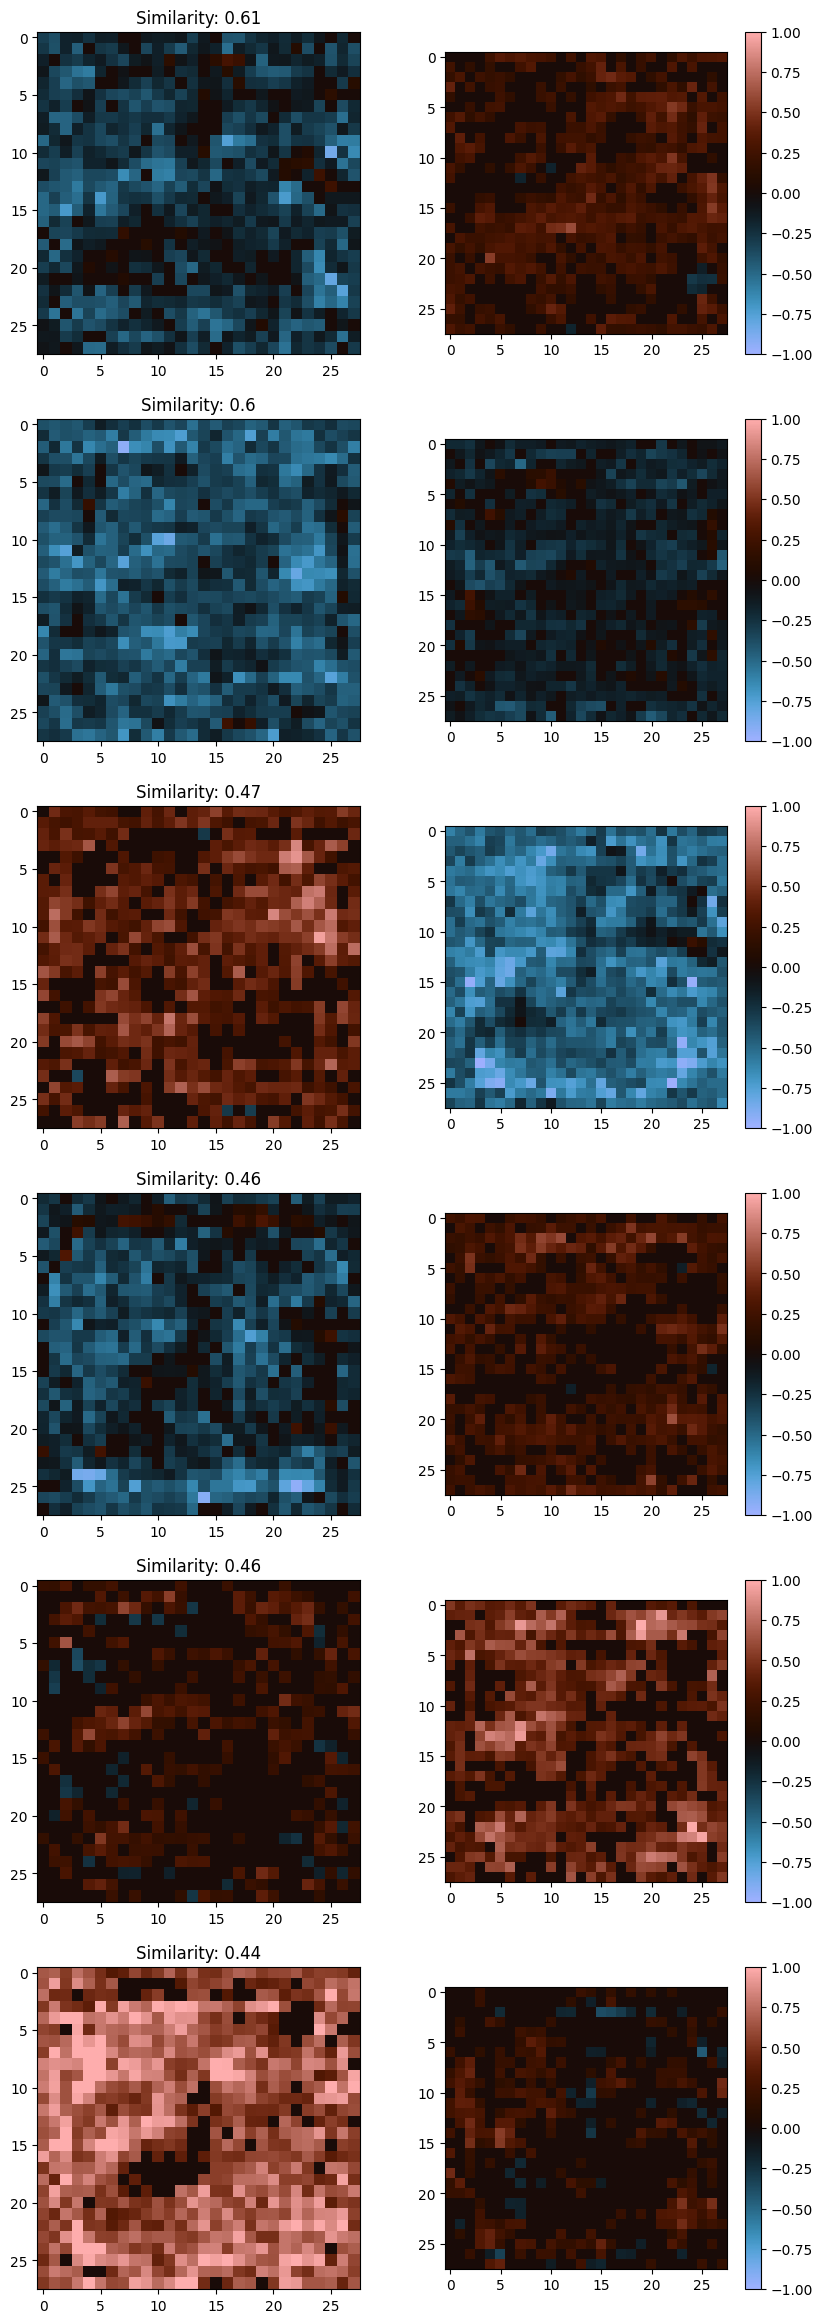

In [17]:
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment

def normalize_map(t):
    return (t - t.mean()) / (t.std() + 1e-8)

def similarity_score(map1, map2):
    a = normalize_map(map1).view(-1)
    b = normalize_map(map2).view(-1)
    #return torch.norm(a - b, p=2).item()
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()


mask = (img != 0)
mask_flat = mask.flatten()

flat_imgs = combined_out.view(combined_out.shape[0], -1)
flat_imgs1 = combined_out1.view(combined_out1.shape[0], -1)

masked_imgs = flat_imgs[:, mask_flat]
masked_imgs1 = flat_imgs1[:, mask_flat]

sim_matrix = torch.zeros((10, 10))
 
for i in range(10):
    for j in range(10):
        sim_matrix[i, j] = similarity_score(masked_imgs[i], masked_imgs1[j])

cost = -sim_matrix.numpy()
row_ind, col_ind = linear_sum_assignment(cost)
max_vals = sim_matrix[row_ind, col_ind].tolist()

pairs = list(zip(row_ind, col_ind, max_vals))
pairs.sort(key=lambda x: x[2], reverse=True)


plt.figure(figsize=(10, 160))

for i, (r, c, sim) in enumerate(pairs):
    if r >= 16: break
    
    plt.subplot(32, 2, i*2+1)
    plt.imshow(combined_out[r], cmap="berlin", vmin=-1, vmax=1)
    plt.title(f"Similarity: {round(sim, 2)}")
    plt.subplot(32, 2, i*2+2)
    plt.imshow(combined_out1[c], cmap="berlin", vmin=-1, vmax=1)
    plt.colorbar()

    if i > 4:
        break


#calculate mean:
sum_sims = 0
sims = []
for i, (r, c, sim) in enumerate(pairs):
    sum_sims += sim
    sims.append(sim)
    
sum_mean = sum_sims / len(pairs)
sum_med = float(torch.median(torch.Tensor(sims)))
sum_max = max(sims)
sum_min = min(sims)

sum_mean, sum_med, sum_max, sum_min

In [18]:
#scattered neuron attention makes neurons recognising human concepts very unlikely, since human concepts are normally localised and continuously connected pixels.
#therefore the neurons wouldn't have such scattered attention, inevitably summing pixels from all over the input,
#(their attention is not focused, which will be forcibly adapted in 07_isolated_attention.ipynb) because they don't learn consistent human-interpretable concepts.
#Furthermore, they overfit on pixel arrangements and style, which I will further elaborate on in 05_model_limitations.ipynb and in the paper.